# Обучение полносвязной нейронной сети.

In [1]:
import numpy as np

# Реализация нейронной сети
Здесь реализовано обучение полносвязной нейронной сети для распознавания рукописных цифр.
Для начала нам понадобится реализовать прямой и обратный проход через слои. Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

In [2]:
class IdentityLayer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           
    output = layer.forward(input)
    
    - Propagate gradients through itself:    
    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters.
    
    Modified code from cs.hse DL course *
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) 
        and auxiliary stuff. You should enumerate all parameters
        in self.params"""
        # An identity layer does nothing
        self.params = []
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], 
        returns output data [batch, output_units]
        """
        # An identity layer just returns whatever it gets as input.
        self.input = input
        return input

    def backward(self, grad_output): 
        """
        Performs a backpropagation step through the layer, 
        with respect to the given input.
        
        To compute loss gradients w.r.t input, 
        you need to apply chain rule (backprop):
        
        d loss / d input  = (d loss / d layer) *  (d layer / d input)
        
        Luckily, you already receive d loss / d layer as input, 
        so you only need to multiply it by d layer / d x.
        
        The method returns:
        * gradient w.r.t input (will be passed to 
          previous layer's backward method)
        * flattened gradient w.r.t. parameters (with .ravel() 
          applied to each gradient). 
          If there are no params, return []
        """
        # The gradient of an identity layer is precisely grad_output
        input_dim = self.input.shape[1]
        
        d_layer_d_input = np.eye(input_dim)
        
        return np.dot(grad_output, d_layer_d_input), [] # chain rule


# Слой нелинейности ReLU
Реализуем слой нелинейности $ReLU(x) = max(x, 0)$ (параметров у слоя нет). Метод forward должен вернуть результат поэлементного применения ReLU к входному массиву, метод backward - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0.

In [3]:
class ReLU:
    """
    Modified code from cs.hse DL course *
    """
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        self.params = [] # ReLU has no parameters
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, num_units] matrix"""
        self.forward_output = np.where(input>0, input, 0)
        return self.forward_output 
    
    def backward(self, grad_output):
        """Compute gradient of loss w.r.t. ReLU input
        grad_output shape: [batch, num_units]
        output 1 shape: [batch, num_units]
        output 2: []
        """ 
        grad = grad_output*(self.forward_output>0)
        return grad, []

# Полносвязный слой
Далее реализуем полносвязный слой без нелинейности. У слоя два параметра: матрица весов и вектор сдвига.

Во втором аргументе надо возвращать градиент по всем параметрам в одномерном виде (сначала применяем .ravel() ко всем градиентам, а затем воспользоваться np.r_):

In [4]:
class Dense:
    """
    Modified code from cs.hse DL course *
    """
    def __init__(self, input_units, output_units):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = xW + b
        """
        # initialize weights with small random numbers from normal distribution
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        self.params = [self.weights, self.biases]
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = xW + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        y = input.dot(self.weights) + self.biases
        self.input = input
        return y
        
    
    def backward(self, grad_output):
        """
        compute gradients
        grad_output shape: [batch, output_units]
        output shapes: [batch, input_units], [num_params]
        
        hint: use function np.r_
        np.r_[np.arange(3), np.arange(3)] = [0, 1, 2, 0, 1, 2]
        """
        grad_x = grad_output.dot(self.weights.T)
        n = grad_output.shape[0]
        grad_w = np.zeros(self.weights.shape)
        for i in range(n):
            grad_w = grad_w + grad_output[i] * self.input[i].reshape(-1, 1)
        grad_b = np.sum(grad_output, axis=0)
        return grad_x, np.r_[grad_w.ravel(), grad_b.ravel()]

In [5]:
l = Dense(128, 150)
assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


# Проверка градиента
Проверим правильность реализации с помощью функции численной проверки градиента. Функция берет на вход callable объект (функцию от одного аргумента-матрицы) и аргумент и вычисляет приближенный градиент функции в этой точке.

In [6]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

Вычислите аналитический и численный градиенты по входу слоя ReLU от функции$$ f(y) = \sum_i y_i, \quad y = ReLU(x) $$

Следующая ячейка после заполнения должна не выдавать ошибку :)

In [7]:
points = np.linspace(-1,1,10*12).reshape([10,12])
l = ReLU()
val = l.forward(points)
grads = l.backward(np.ones([10,12]))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(), x=points)
assert np.allclose(grads[0], numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

Вычислите аналитический и численный градиенты по входу полносвязного слоя от функции$$ f(y) = \sum_i y_i, \quad y = W x + b $$

In [17]:
x = np.linspace(-1, 1, 10*12).reshape([10, 12])
l = Dense(12, 32,)
val = l.forward(x)
grads = l.backward(np.ones([10,32]))[0]
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(), x=points)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

# Softmax

Реализация softmax-слоя и функции потерь
Для решения задачи многоклассовой классификации обычно используют softmax в качестве нелинейности на последнем слое, чтобы получить вероятности классов для каждого объекта:$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}$$В этом случае удобно оптимизировать логарифм правдоподобия:$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$где $y_i=1$, если объект принадлежит $i$-му классу, и 0 иначе. Записанная в таком виде, эта функция потерь совпадает с выражением для кросс-энтропии. Очевидно, что ее также можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:$$L(y, \hat y) = - \log \hat y_{y_i} \rightarrow \min$$В таком виде ее удобно реализовывать.

Реализуем слой Softmax (без параметров). Метод forward должен вычислять логарифм от softmax, а метод backward - пропускать градиенты. В общем случае в промежуточных вычислениях backward получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде. Поэтому мы будем предполагать, что аргумент grad_output - это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

In [8]:
from scipy.special import logsumexp, softmax
# use this function instead of np.log(np.sum(np.exp(...))) !
# because it is more stable

In [9]:
class Softmax:
    def __init__(self):
        self.params = []
        
    def forward(self, input):
        """
        Applies softmax to each row and then applies component-wise log
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        """
        self.n = input.shape[0]
        self.m = input.shape[1]
        self.str_max_input = input.max(axis=1).reshape(self.n,1)
        y = input - self.str_max_input - logsumexp(input - self.str_max_input, axis=1).reshape(self.n, 1)
        self.input = input
        return y
        
    def backward(self, grad_output):
        """
        Propagartes gradients.
        Assumes that each row of grad_output contains only 1 
        non-zero element
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        Do not forget to return [] as second value (grad w.r.t. params)
        """
        grad_x = np.zeros((self.n, self.m))
        i, j = np.where(grad_output==-1)
        denom = np.exp(self.input - self.str_max_input).sum(axis=1)
        grad_x = - np.exp(self.input - self.str_max_input)/denom.reshape(self.n,1)
        grad_x[i,j] = 1 + grad_x[i,j]
        return -grad_x, []

Реализуем функцию потерь и градиенты функции потерь.

In [14]:
def crossentropy(activations, target):
    """
    returns negative log-likelihood of target under model represented by
    activations (log probabilities of classes)
    each arg has shape [batch, num_classes]
    output shape: 1 (scalar)
    """
    loss = -(target*activations).sum()
    return loss 
    
    

def grad_crossentropy(activations, target):
    """
    returns gradient of negative log-likelihood w.r.t. activations
    each arg has shape [batch, num_classes]
    output shape: [batch, num-classes]
    
    hint: this is just one-hot encoding of target vector
          multiplied by -1
    """
    return - target

# Загрузка данных
Мы реализаовали все архитектурные составляющие нашей нейронной сети. Осталось загрузить данные и обучить модель. Мы будем работать с датасетом digits, каждый объект в котором - это 8x8 изображение рукописной цифры.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
from sklearn.datasets import load_digits

In [17]:
X, y = load_digits(return_X_y=True)

In [18]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [19]:
### make one hot target

In [22]:
one_hot_y = np.zeros((y.size, y.max()+1))
one_hot_y[np.arange(y.size),y] = 1
one_hot_y = one_hot_y.astype('int')

In [23]:
X.shape, one_hot_y.shape

((1797, 64), (1797, 10))

Разделим данные на обучение и контроль:

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=0)

In [26]:
X_train.shape, X_test.shape

((1347, 64), (450, 64))

In [27]:
 y_train.shape, y_test.shape

((1347, 10), (450, 10))

# Сборка и обучение нейронной сети

В нашей реализации нейросеть - это список слоев. Например:

In [28]:
#@title
network = []
hidden_layers_size = 32
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))
network.append(Softmax())

Для проверки, хорошо ли сеть обучилась, нам понадобится вычислять точность (accuracy) на данной выборке. Для этого реализуем функцию, которая делает предсказания на каждом объекте:

In [29]:
def predict(network, X):
    """
    returns predictions for each object in X
    network: list of layers
    X: raw data
    X shape: [batch, features_num]
    output: array of classes, each from 0 to 9
    output shape: [batch]
    """
    for layer in network:
        val = layer.forward(X)
        X = val
    return val

Мы будем обучать параметры нейросети с помощью готовой функции оптимизации из модуля scipy:

In [30]:
from scipy.optimize import minimize


Эта функция имеет стандартный интерфейс: нужно передать callable объект, который вычисляет значение и градиент целевой функции, а также точку старта оптимизации - начальное приближение (одномерный numpy-массив). Поэтому нам понадобятся функции для сбора и задания всех весов нашей нейросети (именно для них мы всегда записывали параметры слоя в список layer.params)

In [31]:
def get_weights(network):
    weights = []
    for layer in network:
        for param in layer.params:
            weights += param.ravel().tolist()
    return np.array(weights)

def set_weights(weights, network):
    i = 0
    for layer in network:
        for param in layer.params:
            l = param.size
            param[:] = weights[i:i+l].\
                             reshape(param.shape)
            i += l

Реализуем ту самую функцию, которую будем передавать в minimize. Эта функция должна брать на вход текущую точку (вектор всех параметров), а также список дополнительных параметров (мы будем передавать через них нашу сеть и обучающие данные) и возвращать значение критерия качества (кросс-энтропия) и его градиент по параметрам модели.

In [32]:
def compute_loss_grad(weights, args):
    """
    takes current weights and computes cross-entropy and gradients
    weights shape: [num_parameters]
    output 1: loss (scalar)
    output 2: gradint w.r.t. weights, shape: [num_parameters]
    
    hint: firstly perform forward pass through the whole network
    then compute loss and its gradients
    then perform backward pass, transmitting first baskward output
    to the previos layer and saving second backward output in a list
    finally flatten all the gradients in this list
    (in the order from the first to the last layer)
    
    Do not forget to set weights of the network!
    """
    network, X, y = args
    set_weights(weights, network)
    val = predict(network, X)
    loss = crossentropy(val, y)
    grad_loss = grad_crossentropy(val, y)
    grad_param = []
    for layer in list(reversed(network)):
        cur_grad = layer.backward(grad_loss)
        if cur_grad[1] != []:
            grad_param.append(cur_grad[1])
        grad_loss = cur_grad[0]
    grad_param = reversed(grad_param)
    v = np.array([])
    for item in grad_param:
        v = np.r_[v, item]
    return loss, v

Теперь мы готовы обучать нашу нейросеть.

In [33]:
weights = get_weights(network)

In [34]:
res = minimize(compute_loss_grad, weights,  # fun and start point
               args=[network, X_train, y_train], # args passed to fun
               method="L-BFGS-B", # optimization method
               jac=True) # says that gradient are computed in fun

<ipython-input-32-ba41149ed0c0>:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if cur_grad[1] != []:


In [35]:
res.keys()

dict_keys(['fun', 'jac', 'nfev', 'njev', 'nit', 'status', 'message', 'x', 'success', 'hess_inv'])

In [36]:
res["nit"] # number of iterations (should be >> 10)

185

In [37]:
res["success"] # should be True

True

In [38]:
res["x"] # leraned weights

array([-2.94619868e-03, -1.88090805e-03,  8.02784727e-03, ...,
       -1.09178339e+00, -2.66342375e+00, -5.76350405e-01])

In [39]:
res['x'].shape

(3466,)

Выведем качество на обучении (X_train, y_train) и на контроле (X_test, y_test).

In [40]:
def accuracy(network, X, y):
    index = np.argmax(predict(network, X), axis=1) 
    pred = np.zeros(y.shape)
    size = y.shape[0]
    pred[np.arange(size),index] = 1
    pred = pred.astype('int') 
    count = 0
    for i in range(size):
        count += pred[i].dot(y[i])
    return count/size

Качество на (X_train, y_train)

In [41]:
accuracy(network, X_train, y_train)

1.0

Качество на (X_test, y_test)

In [42]:
accuracy(network, X_test, y_test)

0.94

У minimize есть также аргумент callback - в нее можно передать функцию, которая будет вызываться после каждой итерации оптимизации. Такую функцию удобно оформить в виде метода класса, который будет сохранять качество на обучении контроле после каждой итерации. Реализуем этот метод в классе Callback:

In [43]:
class Callback:
    def __init__(self, network, X_train, y_train, X_test, y_test, print=False):
        self.network = network
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.print = print
        self.train_acc = []
        self.test_acc = []
        
    def call(self, weights):
        """
        computes quality on train and test set with given weights
        and saves to self.train_acc and self.test_acc
        if self.print is True, also prints these 2 values
        """
        set_weights(weights, self.network)
        train = accuracy(self.network, self.X_train, self.y_train)
        test = accuracy(self.network, self.X_test, self.y_test)
        self.train_acc.append(train)
        self.test_acc.append(test)
        if self.print:
            print('Train:', train)
            print('Test:', test)           

In [44]:
cb = Callback(network, X_train, y_train, X_test, y_test, print=True)
res = minimize(compute_loss_grad, weights,  
               args=[network, X_train, y_train], 
               method="L-BFGS-B",
               jac=True,
               callback=cb.call)

<ipython-input-32-ba41149ed0c0>:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if cur_grad[1] != []:


Train: 0.10616184112843356
Test: 0.08444444444444445
Train: 0.24870081662954716
Test: 0.21777777777777776
Train: 0.2524127691165553
Test: 0.2222222222222222
Train: 0.23459539717891612
Test: 0.24444444444444444
Train: 0.2212323682256867
Test: 0.23555555555555555
Train: 0.25686711210096513
Test: 0.28
Train: 0.40014847809948034
Test: 0.4
Train: 0.38530066815144765
Test: 0.35555555555555557
Train: 0.4610244988864143
Test: 0.44666666666666666
Train: 0.5330363771343727
Test: 0.5511111111111111
Train: 0.5293244246473645
Test: 0.5422222222222223
Train: 0.5649591685226429
Test: 0.5733333333333334
Train: 0.5419450631031922
Test: 0.5311111111111111
Train: 0.6117297698589458
Test: 0.6044444444444445
Train: 0.6310319227913883
Test: 0.6177777777777778
Train: 0.7030438010393467
Test: 0.68
Train: 0.6533036377134372
Test: 0.6555555555555556
Train: 0.7260579064587973
Test: 0.6755555555555556
Train: 0.7498144023756496
Test: 0.7044444444444444
Train: 0.7557535263548627
Test: 0.7288888888888889
Train: 0.78

Изобразим на графике кривую качества на обучени и контроле по итерациям:

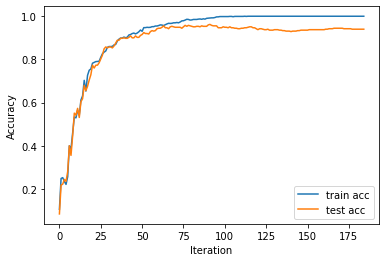

In [45]:
plt.plot(cb.train_acc, label="train acc")
plt.plot(cb.test_acc, label="test acc")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()

## Эксперименты с числом слоев

Ясно, что из-за случайного начального приближения с каждым запуском обучения мы будем получать различное качество. Попробуем обучать нашу нейросеть с разным числом слоев несколько раз.

Заполним матрицы accs_train и accs_test. В позиции [i, j] должна стоять величина точности сети с $i+1$ полносвязными слоями при $j$-м запуске (все запуски идентичны).

In [53]:
accs_test = np.zeros((5, 5))
accs_train = np.zeros((5, 5))

In [60]:
for j in range(5):
    networks = []
    network1 = []
    hidden_layers_size = 32
    network1.append(Dense(X_train.shape[1], 10))
    network1.append(Softmax())
    networks.append(network1)

    network2 = []
    network2.append(Dense(X_train.shape[1], hidden_layers_size))
    network2.append(ReLU())
    network2.append(Dense(hidden_layers_size, 10))
    network2.append(Softmax())
    networks.append(network2)

    network3 = []
    network3.append(Dense(X_train.shape[1], hidden_layers_size))
    network3.append(ReLU())
    network3.append(Dense(hidden_layers_size, hidden_layers_size))
    network3.append(ReLU())
    network3.append(Dense(hidden_layers_size, 10))
    network3.append(Softmax())
    networks.append(network3)

    network4 = []
    network4.append(Dense(X_train.shape[1], hidden_layers_size))
    network4.append(ReLU())
    network4.append(Dense(hidden_layers_size, hidden_layers_size))
    network4.append(ReLU())
    network4.append(Dense(hidden_layers_size, hidden_layers_size))
    network4.append(ReLU())
    network4.append(Dense(hidden_layers_size, 10))
    network4.append(Softmax())
    networks.append(network4)

    network5 = []
    network5.append(Dense(X_train.shape[1], hidden_layers_size))
    network5.append(ReLU())
    network5.append(Dense(hidden_layers_size, hidden_layers_size))
    network5.append(ReLU())
    network5.append(Dense(hidden_layers_size, hidden_layers_size))
    network5.append(ReLU())
    network5.append(Dense(hidden_layers_size, hidden_layers_size))
    network5.append(ReLU())
    network5.append(Dense(hidden_layers_size, 10))
    network5.append(Softmax())
    networks.append(network5)
    for i in range(5):
        cb = Callback(networks[i], X_train, y_train, X_test, y_test, print=False)
        weights = get_weights(networks[i])
        res = minimize(compute_loss_grad, weights,
                       args=[networks[i], X_train, y_train],
                       method="L-BFGS-B",
                       jac=True,
                       callback=cb.call)
        accs_train[i,j] = cb.train_acc[-1]
        accs_test[i,j] = cb.test_acc[-1]

<ipython-input-32-ba41149ed0c0>:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if cur_grad[1] != []:


In [61]:
accs_test

array([[0.94444444, 0.94666667, 0.94      , 0.94222222, 0.94666667],
       [0.94444444, 0.95777778, 0.93777778, 0.96      , 0.94888889],
       [0.95111111, 0.94666667, 0.95555556, 0.93333333, 0.96      ],
       [0.95111111, 0.93555556, 0.94888889, 0.95333333, 0.94666667],
       [0.92      , 0.93333333, 0.94888889, 0.08444444, 0.91777778]])

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце - среднее, прямоугольник показывает разброс).

Text(0.5, 1.0, 'Test quality in 5 runs')

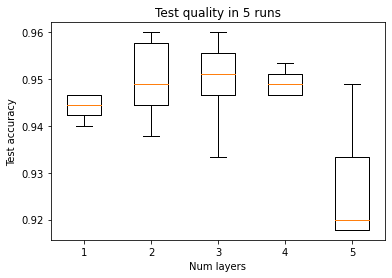

In [62]:
plt.boxplot(accs_test.T, showfliers=False)
plt.xlabel("Num layers")
plt.ylabel("Test accuracy")
plt.title("Test quality in 5 runs")

Как изменяются качество на обучении и контроле и устойчивость процесса обучения при увеличении числа слоев?
* Лучшее среднее значение качества получено при 3х слоях, с 3 до 5 качество убывает. В данном эксперименте при 5 слоях получился наибольший разброс, при одном слое разброс наименьший, значит, более устойчивый процесс обучения.

Несколько фрагментов кода в задании написаны на основе материалов курса по глубинному обучению на ФКН НИУ ВШЭ